In [198]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from scipy.integrate import solve_ivp
from scipy.interpolate import interp1d

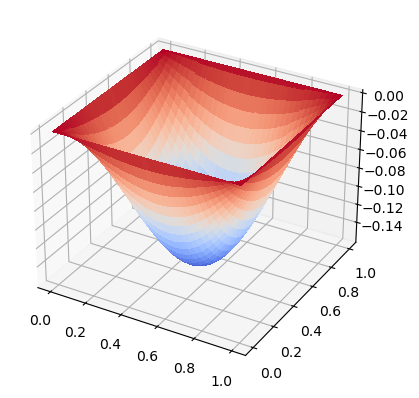

In [199]:
def u(x, y):
    return - (np.sin(np.pi * x) * np.sin(np.pi * x) / (2 * np.pi))

xs = np.linspace(0, 1, 101)
ys = np.linspace(0, 1, 101)

xx, yy = np.meshgrid(xs, ys)
us_real = - (np.sin(np.pi * xx) * np.sin(np.pi * yy) / (2 * np.pi))

fig, ax = plt.subplots(subplot_kw = {"projection": "3d"})
surf = ax.plot_surface(xx, yy, us_real, cmap = cm.coolwarm, linewidth = 0, antialiased = False)
plt.show()


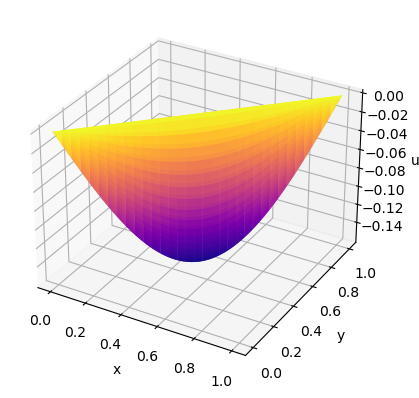

In [200]:
def u(x, y):
    return - (np.sin(np.pi * x) * np.sin(np.pi * x) / (2 * np.pi))

xs = np.linspace(0, 1, 101)
ys = np.linspace(0, 1, 101)

xx, yy = np.meshgrid(xs, ys)
us_real = - (np.sin(np.pi * xx) * np.sin(np.pi * yy) / (2 * np.pi))


fig = plt.figure()
ax = plt.axes(projection = '3d')
ax.plot_surface(xs, ys, us_real, cmap = 'plasma')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('u')
plt.show()

In [201]:
eps = 10**(-5)

def calculate_residuals(solution, boundary_conditions, bc_parameters):
    return boundary_conditions(solution, bc_parameters)

def solve_ivp_wrapper(integration_steps, problem, parameters, approx):
    return np.transpose(solve_ivp(problem, (integration_steps[0], integration_steps[-1]), approx, t_eval = integration_steps, args = [parameters]).y)

def get_frechet_matrix(integration_steps, problem, parameters, approx, residuals, boundary_conditions, bc_parameters) -> np.array:
    delta = eps
    steps_left = integration_steps[len(integration_steps)//2::-1]
    steps_right = integration_steps[len(integration_steps)//2:]
    frechet_matrix = np.empty([len(approx), len(approx)])
    for i in range(len(approx)):
        approx_i = approx.copy()
        approx_i[i] += delta
        solution_i = np.concatenate((solve_ivp_wrapper(steps_left, problem, parameters, approx_i)[::-1], solve_ivp_wrapper(steps_right, problem, parameters, approx_i)[1:]))
        residuals_i = calculate_residuals(solution_i, boundary_conditions, bc_parameters)
        frechet_matrix[:, i] = (residuals_i - residuals) / delta
    return frechet_matrix

def solve(integration_steps, problem, parameters, approx, boundary_conditions, bc_parameters):
    steps_left = integration_steps[len(integration_steps)//2::-1]
    steps_right = integration_steps[len(integration_steps)//2:]
    while True: 
        solution = np.concatenate((solve_ivp_wrapper(steps_left, problem, parameters, approx)[::-1], solve_ivp_wrapper(steps_right, problem, parameters, approx)[1:]))
        residuals = calculate_residuals(solution, boundary_conditions, bc_parameters)
        if np.all(np.abs(residuals) < eps):
            break
        frechet_matrix = get_frechet_matrix(integration_steps, problem, parameters, approx, residuals, boundary_conditions, bc_parameters)
        approx = approx - np.linalg.inv(frechet_matrix) @ residuals
    solution = np.concatenate((solve_ivp_wrapper(steps_left, problem, parameters, approx)[::-1], solve_ivp_wrapper(steps_right, problem, parameters, approx)[1:]))
    return solution 

In [202]:
h = lambda x: np.sin(np.pi * x)
dh = lambda x: np.pi * np.cos(np.pi * x)

g = lambda y: np.sin(np.pi * y)
dg = lambda y: np.pi * np.cos(np.pi * y)

hbc = [0, 0]
gbc = [0, 0]

def f(x, y):
    return np.sin(np.pi * x) * np.sin(np.pi * y)

In [203]:
funcs = {'h': h, 'g': g, 'dh': dh, 'dg': dg}

def boundary_conditions(fdf, bc_parameters):
    f = fdf[:, 0]
    r1 = f[0] - bc_parameters[0]
    r2 = f[-1] - bc_parameters[-1]
    return np.array([r1, r2])

def problem_g_fixed(x, hdh, funcs):  
    h, dh = hdh 
    
    def numerator(y):
        return h * funcs['dg'](y)**2 + f(x, y) * funcs['g'](y)

    def denominator(y):
        return funcs['g'](y)**2
    
    ddh = np.trapz(numerator(ys), ys) / np.trapz(denominator(ys), ys)
    
    return np.array([dh, ddh])

def problem_h_fixed(y, gdg, funcs):  
    g, dg = gdg 
    
    def numerator(x):
        return g * funcs['dh'](y)**2 + f(x, y) * funcs['h'](x)

    def denominator(x):
        return funcs['h'](x)**2
    
    ddg = np.trapz(numerator(xs), xs) / np.trapz(denominator(xs), xs)
    
    return np.array([dg, ddg])

In [204]:
xx, yy = np.meshgrid(xs, ys)
eps2 = 10**(-8)

while True:
    gdg = solve(ys, problem_h_fixed, funcs, np.array([funcs['g'](0.5), funcs['dg'](0.5)]), boundary_conditions, gbc)

    funcs['g_prev'] = funcs['g']
    funcs['g'] = interp1d(ys, gdg[:, 0]) 
    funcs['dg'] = interp1d(ys, gdg[:, 1])

    hdh = solve(xs, problem_g_fixed, funcs, np.array([funcs['h'](0.5), funcs['dh'](0.5)]), boundary_conditions, hbc)

    funcs['h_prev'] = funcs['h']
    funcs['h'] = interp1d(xs, hdh[:, 0]) 
    funcs['dh'] = interp1d(xs, hdh[:, 1]) 

    L2_norm = np.sqrt(np.mean((funcs['h'](xx) * funcs['g'](yy) - funcs['h_prev'](xx) * funcs['g_prev'](yy))**2)) 
    print(L2_norm)
    if L2_norm < eps:
        break

0.5198300188854118
6.103565762316244e-06


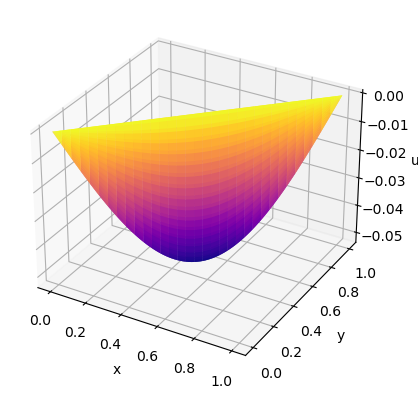

In [205]:
def uu(x, y, funcs):
    return funcs['h'](x) * funcs['g'](y)

xs = np.linspace(0, 1, 101)
ys = np.linspace(0, 1, 101)

us = uu(*np.meshgrid(xs, ys), funcs)

fig = plt.figure()
ax = plt.axes(projection = '3d')
ax.plot_surface(xs, ys, us, cmap = 'plasma')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('u')
plt.show()

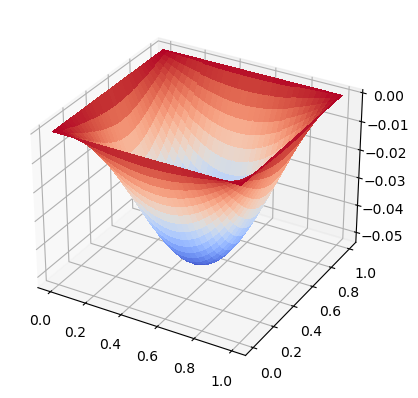

In [206]:
def uu(x, y, funcs):
    return funcs['h'](x) * funcs['g'](y)

xs = np.linspace(0, 1, 101)
ys = np.linspace(0, 1, 101)

xx, yy = np.meshgrid(xs, ys)
us = funcs['h'](xx) * funcs['g'](yy)

fig, ax = plt.subplots(subplot_kw = {"projection": "3d"})
surf = ax.plot_surface(xx, yy, us, cmap = cm.coolwarm, linewidth = 0, antialiased = False)
plt.show()

In [207]:
L2_norm = np.sqrt(np.mean((us - us_real)**2)) 
print(L2_norm)

0.05402192900224756
